## Burger's equation: Two-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.kernel_ridge import KernelRidge 
from parameter_learning import * 
from plotlib import * 
from models import * 
from data_loader_Burgers5 import * 
from scipy import interpolate 

import matplotlib.tri as tri 
import matplotlib.pyplot as plt 

from jax.config import config; 
config.update("jax_enable_x64", True) 

(100, 320)


In [3]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [4]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P_train', 'rkhs_P_train', 'f_gh_tr_pred']
two_step_dict = dict.fromkeys(keys)

### Solution: Two-Step Method

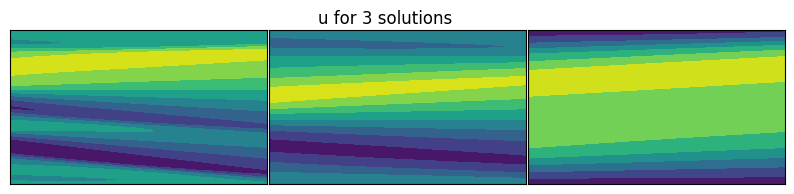

In [5]:
# u values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('u for {} solutions'.format(m))
axs = axs.ravel()
for i in range(m): 
    axs[i].tricontourf(X[i*N:(i+1)*N,0], X[i*N:(i+1)*N,1], U[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

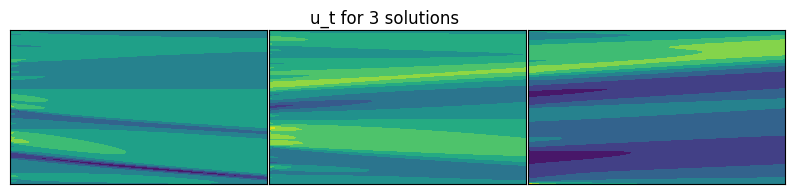

In [6]:
# u_t values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('u_t for {} solutions'.format(m))
axs = axs.ravel()
for i in range(m):
    axs[i].tricontourf(X[i*N:(i+1)*N,0], X[i*N:(i+1)*N,1], U_t[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

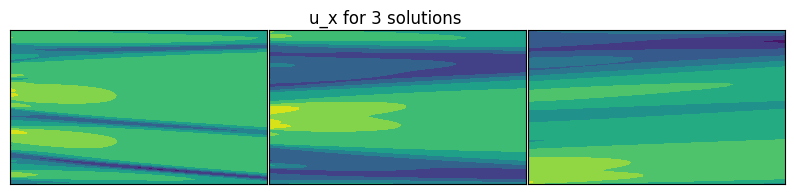

In [7]:
# u_x values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('u_x for {} solutions'.format(m))
axs = axs.ravel()
for i in range(m): 
    axs[i].tricontourf(X[i*N:(i+1)*N,0], X[i*N:(i+1)*N,1], U_x[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

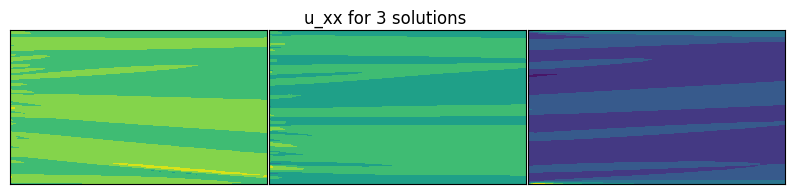

In [8]:
# u_xx values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('u_xx for {} solutions'.format(m))
axs = axs.ravel()
for i in range(m): 
    axs[i].tricontourf(X[i*N:(i+1)*N,0], X[i*N:(i+1)*N,1], U_xx[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

### > Step 1: Learning $u's$

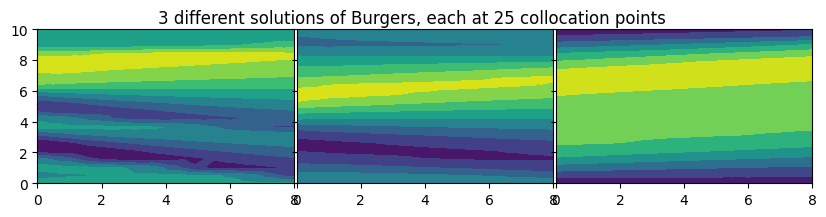

In [9]:
# u values at collocation at ghost_training points of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('{} different solutions of Burgers, each at {} collocation points'.format(m, N_tr))
axs = axs.ravel()
for i in range(m):
    axs[i].tricontourf(X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,0], X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,1], U_gh_tr[:,i])
    #axs[i].pcolormesh(TT_tr[0,:], XX_tr[:,0], U_tr[:,i].reshape(N_t_tr,N_x_tr))
    # axs[i].set_yticklabels([])
    # axs[i].set_xticklabels([])
    # axs[i].set_yticks([])
    # axs[i].set_xticks([])

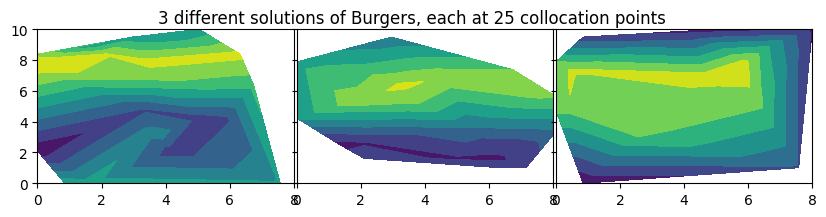

In [10]:
# u values at collocation points of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('{} different solutions of Burgers, each at {} collocation points'.format(m, N_tr))
axs = axs.ravel()
for i in range(m):
    axs[i].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr[:,i])
    #axs[i].pcolormesh(TT_tr[0,:], XX_tr[:,0], U_tr[:,i].reshape(N_t_tr,N_x_tr))
    # axs[i].set_yticklabels([])
    # axs[i].set_xticklabels([])
    # axs[i].set_yticks([])
    # axs[i].set_xticks([])

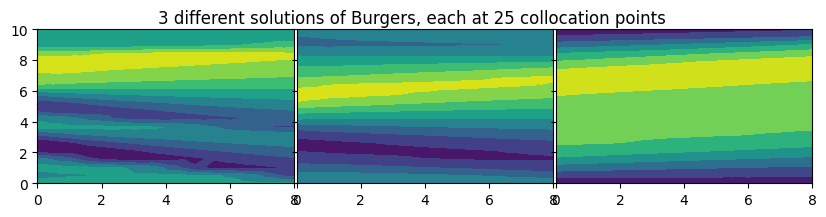

In [11]:
# u values at testing points of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('{} different solutions of Burgers, each at {} collocation points'.format(m, N_tr))
axs = axs.ravel()
for i in range(m):
    axs[i].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te[:,i])
    #axs[i].pcolormesh(TT_tr[0,:], XX_tr[:,0], U_tr[:,i].reshape(N_t_tr,N_x_tr))
    # axs[i].set_yticklabels([])
    # axs[i].set_xticklabels([])
    # axs[i].set_yticks([])
    # axs[i].set_xticks([])

In [12]:
# Learn alphas and lenght scale
optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)

In [13]:
# Save true values to be used in one-step 
two_step_dict['optim_sgm_u'] = optim_sgm_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u 
optim_sgm_u, optim_nugget_u 

(array([3.248985  , 3.86805308, 5.06207323]), array([1.e-08, 1.e-08, 1.e-08]))

In [14]:
# Predict using interpolant and get its gradients 
U_tr_pred, U_t_tr_pred, U_x_tr_pred, U_xx_tr_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
U_te_pred, U_t_te_pred, U_x_te_pred, U_xx_te_pred = predictions_Burgers_te(X_te, X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr, N_te)
U_gh_tr_pred, U_t_gh_tr_pred, U_x_gh_tr_pred, U_xx_gh_tr_pred = predictions_Burgers_te(X_gh_tr, X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr, N_gh_tr)

In [15]:
# Save true values to warm up the onepfive method
np.save('data/U_tr_pred.npy', U_tr_pred)
np.save('data/U_te_pred.npy', U_te_pred)
np.save('data/U_gh_tr_pred.npy', U_gh_tr_pred)
# Save true gradients for comparing later  
np.save('data/U_t_tr.npy', U_t_tr) 
np.save('data/U_x_tr.npy', U_x_tr) 
np.save('data/U_xx_tr.npy', U_xx_tr) 

# Save gradients for one step method
# U_x
np.save('data/U_x_tr_pred.npy', U_x_tr_pred)
np.save('data/U_x_gh_tr_pred.npy', U_x_gh_tr_pred)
np.save('data/U_x_te_pred.npy', U_x_te_pred)
# U_xx
np.save('data/U_xx_tr_pred.npy', U_xx_tr_pred)
np.save('data/U_xx_gh_tr_pred.npy', U_xx_gh_tr_pred)
np.save('data/U_xx_te_pred.npy', U_xx_te_pred)

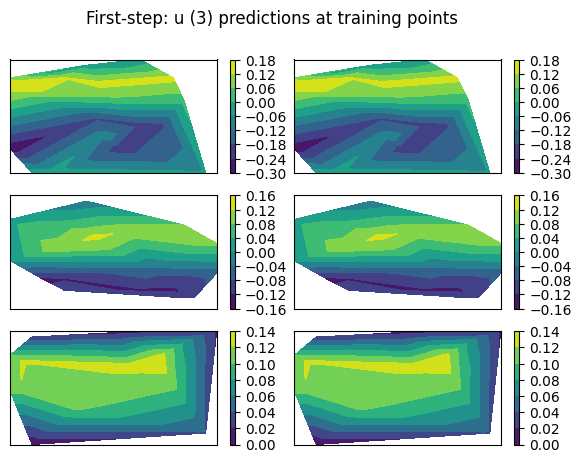

In [16]:
# Plot: u at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

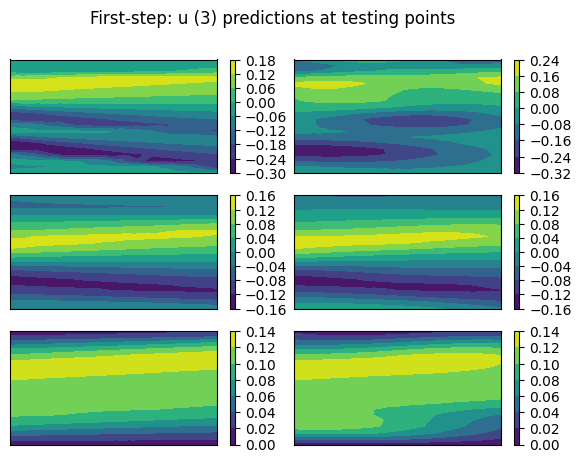

In [17]:
# Plot: u at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [18]:
# NMSEs: u at training points and testing points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(U_tr_pred[:,i], U_tr[:,i])/mean_squared_error(U_tr_pred[:,i]*0, U_tr[:,i])
    n_mse_test = mean_squared_error(U_te_pred[:,i], U_te[:,i])/mean_squared_error(U_te_pred[:,i]*0, U_te[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 3 functions
m = 0 nmse_train = 1.879784990519243e-14
m = 0 nmse_test = 0.18461175149658587
m = 1 nmse_train = 2.2679756243593125e-13
m = 1 nmse_test = 0.03403322332236119
m = 2 nmse_train = 7.950889600771492e-12
m = 2 nmse_test = 0.01563766377979467


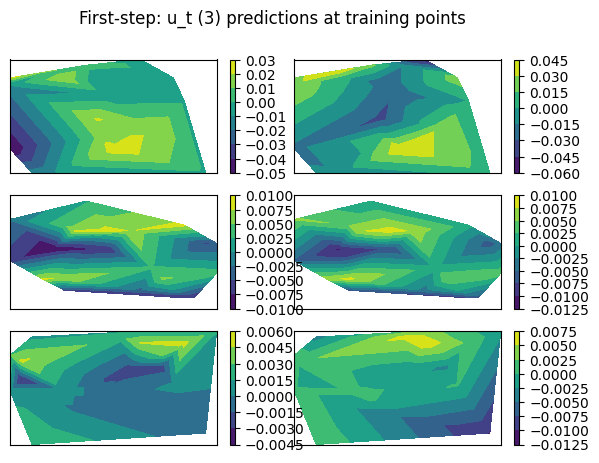

In [19]:
# Plot: u_t at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_t_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_t_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

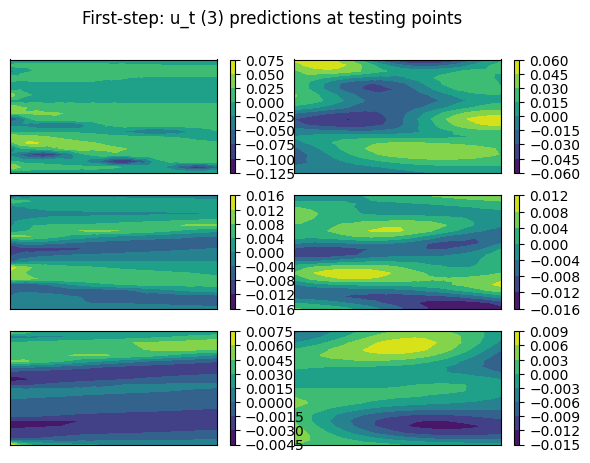

In [20]:
# Plot: u_t at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_t_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_t_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [21]:
# NMSEs: u_t at training points and testing points
print('Normalized MSEs between u_t and u_t_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(U_t_tr_pred[:,i], U_t_tr[:,i])/mean_squared_error(U_t_tr_pred[:,i]*0, U_t_tr[:,i])
    n_mse_test = mean_squared_error(U_t_te_pred[:,i], U_t_te[:,i])/mean_squared_error(U_t_te_pred[:,i]*0, U_t_te[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_t and u_t_pred for 3 functions
m = 0 nmse_train = 2.2637973299840253
m = 0 nmse_test = 1.780268143358721
m = 1 nmse_train = 0.18090479018814165
m = 1 nmse_test = 0.6753452434521235
m = 2 nmse_train = 1.2161580310030669
m = 2 nmse_test = 2.9816890696494522


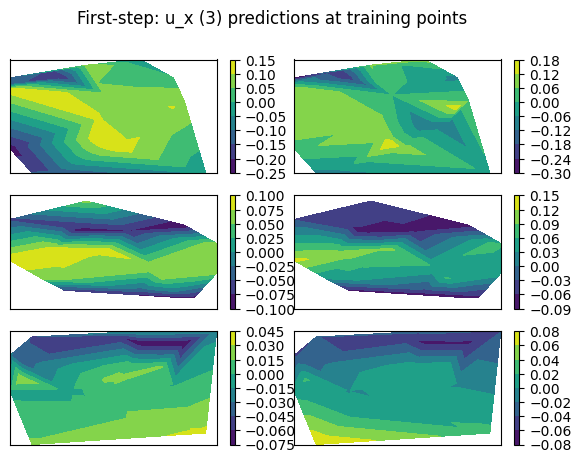

In [22]:
# Plot: u_x at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

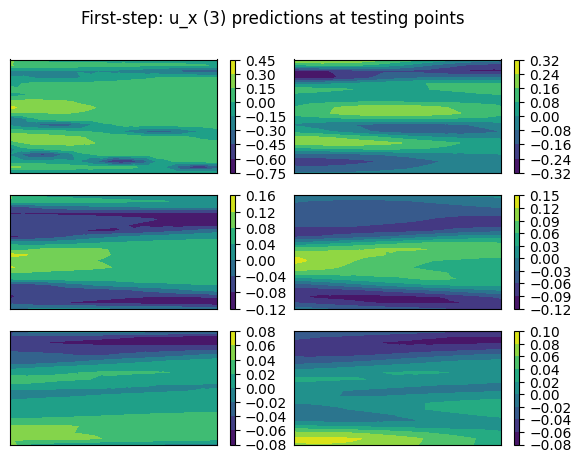

In [23]:
# Plot: u_x at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [24]:
# NMSEs: u_x at training points and testing points
print('Normalized MSEs between u_x and u_x_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(U_x_tr_pred[:,i], U_x_tr[:,i])/mean_squared_error(U_x_tr_pred[:,i]*0, U_x_tr[:,i])
    n_mse_test = mean_squared_error(U_x_te_pred[:,i], U_x_te[:,i])/mean_squared_error(U_x_te_pred[:,i]*0, U_x_te[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_x and u_x_pred for 3 functions
m = 0 nmse_train = 0.7240354719176492
m = 0 nmse_test = 0.656907381659664
m = 1 nmse_train = 0.10794955083136347
m = 1 nmse_test = 0.19649784445738255
m = 2 nmse_train = 0.2374029428662991
m = 2 nmse_test = 0.3779950404508254


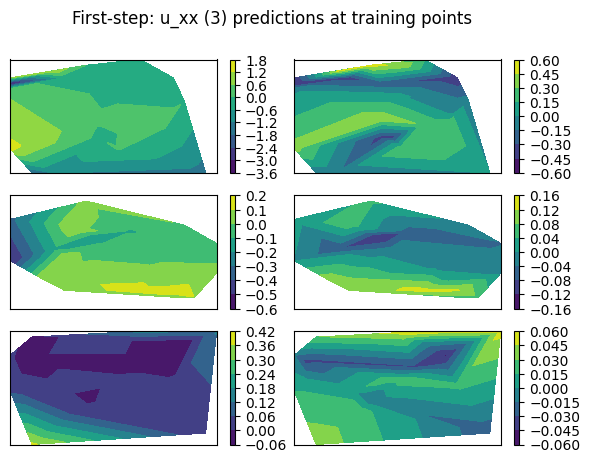

In [25]:
# Plot: u_xx at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_xx_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_xx_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

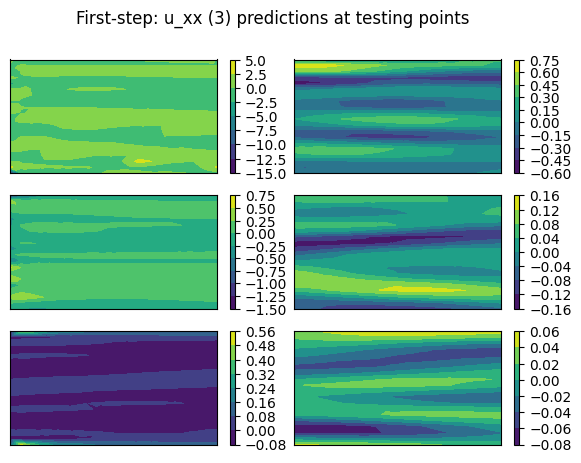

In [26]:
# Plot: u_xx at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_xx_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_xx_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [27]:
# NMSEs: u_xx at training points and testing points
print('Normalized MSEs between u_xx and u_xx_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(U_xx_tr_pred[:,i], U_xx_tr[:,i])/mean_squared_error(U_xx_tr_pred[:,i]*0, U_xx_tr[:,i])
    n_mse_test = mean_squared_error(U_xx_te_pred[:,i], U_xx_te[:,i])/mean_squared_error(U_xx_te_pred[:,i]*0, U_xx_te[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_xx and u_xx_pred for 3 functions
m = 0 nmse_train = 0.8129647984075489
m = 0 nmse_test = 0.9559153402993528
m = 1 nmse_train = 0.7819158790933464
m = 1 nmse_test = 0.825444514293918
m = 2 nmse_train = 0.6905595977842864
m = 2 nmse_test = 0.7394072994185393


RKHSs norms squared $u^*$

In [28]:
rkhs_u = []
G = K_2D(Gaussian2D, X_tr, X_tr, optim_sgm_u)
G = G[:,:,0] + 1e-7*jnp.diag(jnp.diag(G[:,:,0])) # I had to regularize here (?)
alphas = np.linalg.solve(G, U_tr_pred.flatten())
rkhs_u.append(np.dot(U_tr_pred.flatten(), alphas))
# Print the norm
print('RKHS^2 norm of u^*: {}'.format(round(rkhs_u[0],2)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

RKHS^2 norm of u^*: 1208805.04


We compute the norm of $u_*$ since it is more regular than $u$.

> Step 2: Learning $P$

In [29]:
s_train = np.hstack((X_tr, U_tr.T.reshape(-1,1), U_x_tr_pred.T.reshape(-1,1), U_xx_tr_pred.T.reshape(-1,1))) # (m*N_tr, 5)
s_test = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1),U_xx_te_pred.T.reshape(-1,1))) # (m*N_te, 5)
s_gh_tr = np.hstack((X_gh_tr, U_gh_tr.T.reshape(-1,1), U_x_gh_tr_pred.T.reshape(-1,1),U_xx_gh_tr_pred.T.reshape(-1,1))) # (m*N_te, 5)

f_train = U_t_tr.T.reshape(-1,1)
f_test = U_t_te.T.reshape(-1,1)
f_gh_tr = U_t_gh_tr.T.reshape(-1,1)

scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)
s_gh_tr_s = scaler_s_train.transform(s_gh_tr)

f_train2 = -s_train[:,2]*s_train[:,3] + 0.01*s_train[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]

In [30]:
optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)
#optim_d_P, optim_nugget_P = 2, 1e-16
# Save true values to be used in one-step
two_step_dict['optim_sgm_P'] = optim_sgm_P
#two_step_dict['optim_sgm_P'] = optim_d_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
#krr_optimal_P = KernelRidge(kernel='poly', alpha = optim_nugget_P, degree = optim_d_P) 

krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_train = f_pred_train.flatten() 
f_pred_test = krr_optimal_P.predict(s_test_s)
f_pred_test = f_pred_test.flatten() 
f_gh_tr_pred = krr_optimal_P.predict(s_gh_tr_s)
f_gh_tr_pred = f_gh_tr_pred.flatten() 

In [31]:
print('Optimal sigma of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_sgm_P,optim_nugget_P))
#print('Degree for kernel of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_d_P,optim_nugget_P))

Optimal sigma of P^*:0.1591114015506264  Nugget of P^*: 1.00e-14


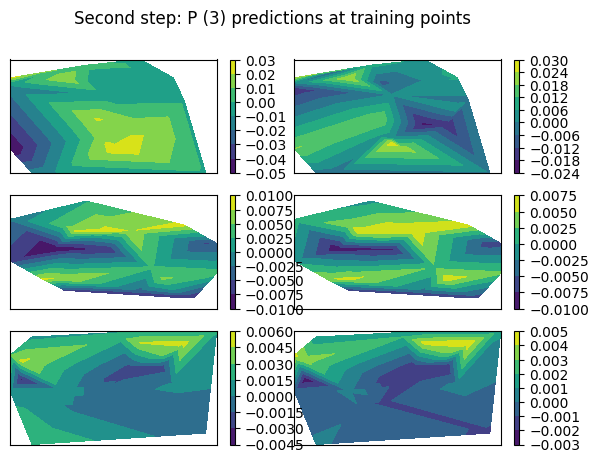

In [32]:
# Plot: P at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], f_pred_train[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], f_train2[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

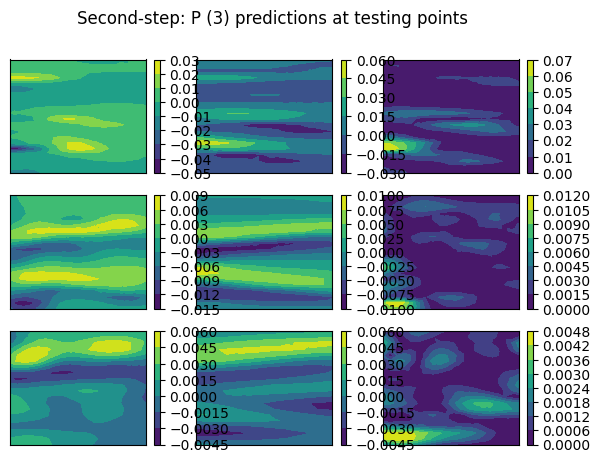

In [33]:
# Plot: P at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_pred_test[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_test2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_test2[i*N_te:(i+1)*N_te]-f_pred_test[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [34]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P^ for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(f_pred_train[i*N_tr:(i+1)*N_tr], f_train2[i*N_tr:(i+1)*N_tr])/mean_squared_error(f_pred_train[i*N_tr:(i+1)*N_tr]*0, f_train2[i*N_tr:(i+1)*N_tr])
    n_mse_test = mean_squared_error(f_pred_test[i*N_te:(i+1)*N_te], f_test2[i*N_te:(i+1)*N_te])/mean_squared_error(f_pred_test[i*N_te:(i+1)*N_te]*0, f_test2[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P^ for 3 functions
m = 0 nmse_train = 1.871601133104874
m = 0 nmse_test = 1.020587606449843
m = 1 nmse_train = 0.10673009657073539
m = 1 nmse_test = 0.2979859550873303
m = 2 nmse_train = 0.1648624658690006
m = 2 nmse_test = 0.42570391093618654


RKHS norm squared of $P^*$

In [35]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,s_train_s,s_train_s, optim_sgm_P) + nugget_P*np.eye(X_tr.shape[0]) # added nugget here !
alphas_P = np.linalg.solve(G, f_pred_train)
rkhs_P_train = np.dot(f_pred_train, alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_train,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P_train'] = rkhs_P_train
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 0.01


In [36]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,s_test_s,s_test_s, optim_sgm_P) + nugget_P*np.eye(X_te.shape[0]) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_pred_test)
rkhs_P_test = np.dot(f_pred_test,alphas_P_test)
two_step_dict['rkhs_P_test'] = rkhs_P_test
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 0.01


In [37]:
two_step_dict['f_gh_tr_pred'] = f_gh_tr_pred

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `s_train` and perturb feature 1 of `s_train` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

100%|██████████| 5/5 [43:12<00:00, 518.49s/it]


[[0.02144591 0.0213291  0.02111999 0.02117304 0.02182763]
 [0.02144591 0.02119702 0.02147921 0.0218008  0.02348154]
 [0.02144591 0.02152744 0.02155479 0.02112067 0.02241559]
 [0.02144591 0.02172191 0.02096087 0.02154834 0.02130895]
 [0.02144591 0.02161815 0.02147831 0.02121684 0.02201806]]


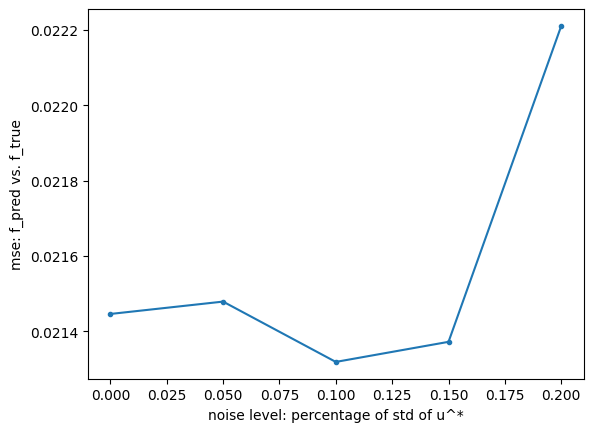

In [40]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(s_train, axis = 0)
    beta = np.arange(0.0,0.25,0.05)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(s_train)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,2] = np.random.normal(s_train[:,2] , scale = scale[2])
        # Apply step one to perturbed u's 
        optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)
        _, _, u_x_pred, u_xx_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
        s_test[:,3] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

Graph above was generated by using a polynomial kernel for learning P.

In [38]:
np.save('data/two_step_dict.npy',two_step_dict)